# Abstract

# Data Preparation and Package Installation

Loading the ACS data from Missouri and selecting the features we want to train on.

In [3]:
import warnings
warnings.filterwarnings('ignore')
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "MO"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

# filte the data to only use recommended features
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,27,17.0,5,16,2,NaN,1,3.0,4.0,4,1,2,2,2.0,2,1,6.0
1,42,19.0,5,16,2,NaN,1,3.0,4.0,1,1,2,2,2.0,1,2,6.0
2,20,19.0,5,17,2,NaN,1,1.0,4.0,2,1,2,2,2.0,1,1,1.0
3,26,17.0,5,16,1,NaN,1,1.0,4.0,1,1,2,2,1.0,1,2,6.0
4,37,16.0,5,16,1,NaN,1,3.0,4.0,1,1,2,1,1.0,1,2,6.0


Transforming the features into a basic problem to address the task of predicting employment status while excluding race as a demographic.

In [4]:
# subset the features we want to use
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

# construct a basic problem to predict employment status without considering race
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

# separate into a feature matrix, label vector, and a group label vector
features, label, group = EmploymentProblem.df_to_numpy(acs_data)

Split into a training and test split.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

# Assessing Initial Variance

Lets now look at some basic descriptives.

There are 49932 individuals in the dataset 

There are 22306 individuals in the dataset are currently employed 

The number of individuals in each group: 
group
1    43713
2     3838
3      150
4        5
5       27
6      762
7       51
8      316
9     1070
dtype: int64

The proportion of individuals in each group that are currently employed: 
group
1    0.454396
2    0.395779
3    0.460000
4    0.600000
5    0.407407
6    0.493438
7    0.529412
8    0.373418
9    0.299065
Name: label, dtype: float64


Text(0, 0.5, 'Proportion Employed')

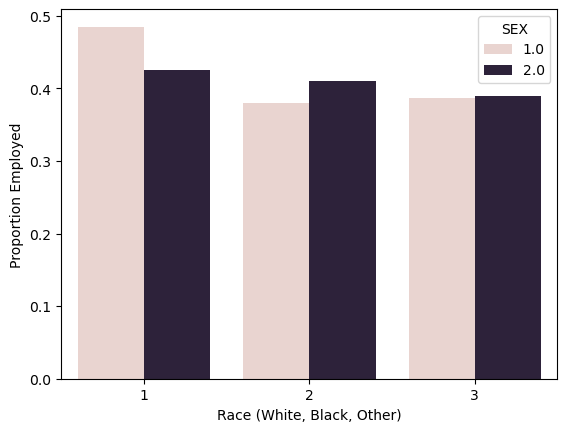

In [6]:
import pandas as pd
import seaborn as sns

# convert the data back into a dataframe to make it easier to work with
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train

# how many individuals are there in the data
print("There are " + str(len(df)) + " individuals in the dataset \n")

# how many individuals are currently employed
print("There are " + str(len(df[df["label"] == 1])) + " individuals in the dataset are currently employed \n")

# how many individuals in each group
print("The number of individuals in each group: ")
print(df.groupby("group").size())

# proportion of individuals in each group that are currently employed
print("\nThe proportion of individuals in each group that are currently employed: ")
print(df.groupby("group")["label"].mean())

# lets now add sex to the consideration of race and proportion predicted to be employed
temp  = df.copy()
temp["group"][temp["group"] > 2] = 3
ax = sns.barplot(data = temp, x = "group", y = "label", hue = "SEX", errorbar = None)
ax.set_xlabel("Race (White, Black, Other)")
ax.set_ylabel("Proportion Employed")

While there is some variance across sex and race in the employment rate, for the most part the employment rate is approximately equal across all groups. Although both white females and males are more employed more than any other subgroup. 

# Training a Model

Lets train a model using a decision tree classifier with an optimal model complexity. Select model complexity based on the complexity that gets the higest accuracy and the lowest standard deviation.

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# assess 50 model complexities

complexity = []

for i in range(1, 50, 1):
    # fit a model with the given complexity
    m = DecisionTreeClassifier(max_depth = i)
    m.fit(X_train, y_train)

    # assess accuracy
    test_hat = m.predict(X_test)
    test_acc = (test_hat == y_test).mean()

    # store this result
    complexity.append((test_acc, i))

complexity.sort(reverse = True)

print("Purely by accuracy, the best five model complexities are: " + str(complexity[:5]))


Purely by accuracy, the best five model complexities are: [(0.8406760653636655, 7), (0.8403556552387056, 9), (0.8399551425825056, 8), (0.8397148349887856, 10), (0.8393143223325857, 6)]


Assess these models to find which one is most consistent by checking with cross validation.

In [8]:
from sklearn.model_selection import cross_val_score

# pull out the top 5 complexities
best_complexity = []
for comp in complexity:
    best_complexity.append(comp[1])

best_complexity = best_complexity[:5]
best_comp = 0
best_std = float("inf")

# assess which of the best complexities has the lowest standard deviation in cross validation
for comp in best_complexity:
    # fit the model
    m = DecisionTreeClassifier(max_depth = comp)
    m.fit(X_train, y_train)

    # assess cross validation
    cv_scores = cross_val_score(m, X_train, y_train, cv = 5)
    std = np.std(cv_scores)

    if std < best_std:
        best_std = std
        best_comp = comp

print("The model complexity that minimizes standard devition is: " + str(best_comp) + " with a standard deviation of: " + str(best_std))

The model complexity that minimizes standard devition is: 10 with a standard deviation of: 0.003016699029675894


Lets now fit the model using our optimal depth into our pipeline.

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# fit the model into our pipeline

model = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth = best_comp))
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10))])

In [ ]:
# pull predictions from the model based on the test data
y_hat = model.predict(X_test)

# assess the model's overall predicitve accuracy
print("The overall testing accuracy is: " + str((y_hat == y_test).mean()))

# asses the model's predictive accuracy for white individuals
print("The testing accuracy for white individuals is: " + str((y_hat == y_test)[group_test == 1].mean()))

# assess the model's predicitve accuracy for black individuals
print("The testing accuracy for black individuals is: " + str((y_hat == y_test)[group_test == 2].mean()))

# assess the model's predicitve accuracy for others
print("The testing accuracy for other racial groups is: " + str((y_hat == y_test)[group_test == 3].mean()))

The overall testing accuracy is: 0.8396347324575456
The testing accuracy for whites is: 0.8391858439534244
The testing accuracy for blacks is: 0.8453276047261009
The testing accuracy for other racial groups is: 0.868421052631579


The model has an approximately equal prediction rate for employment status across racial groups. In this model white individuals are the least likely to be predicted as employed, black individuals are slightly more likely, and members of all other racial groups are more likely as a whole. Lets now look at the positive predictive value as well as the false negative and false positive rates of the model. 

In [21]:
# calculate the overall PPV
TP = np.sum((y_hat == y_test) & (y_hat == 1))
FP = np.sum((y_hat != y_test) & (y_hat == 1))
PPV = TP / (TP + FP)
print("The overall positive predictive value of our model is: " + str(PPV))

# calculate the overall FNR
FN = np.sum((y_hat != y_test) & (y_hat == 0))
FNR = FN / (FN + TP)
print("The overall false negative rate of our model is: " + str(FNR))

# calculate the overall FPR
TN = np.sum((y_hat == y_test) & (y_hat == 0))
FPR = FP / (FP + TN)
print("The overall false positive rate of our model is: " + str(FPR))


The overall positive predictive value of our model is: 0.8006578947368421
The overall false negative rate of our model is: 0.13962530929657122
The overall false positive rate of our model is: 0.17755640199238207
